In [17]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50
from torchvision import transforms
import matplotlib.pyplot as plt
import json

In [3]:
# Note: some of this code was gratefully based on from https://adversarial-ml-tutorial.org/introduction/


preprocess_resnet50 = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
normalize_resnet50 = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [5]:
# Load the picture as a tensor, preprocess
espresso_tensor = preprocess_resnet50(Image.open("../../data/pictures/kopje.jpg"))[None,:,:,:]

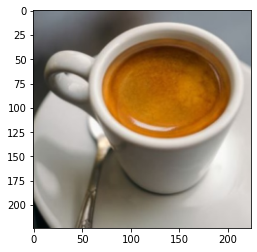

In [7]:
# Show the initial picture
plt.imshow(espresso_tensor[0].numpy().transpose(1,2,0));

In [12]:
# Load a pretrained ResNet50 model
model = resnet50(pretrained=True)
model.eval();
with open("../../data/models/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

In [30]:
pred = model(normalize_resnet50(espresso_tensor))

In [33]:
# Print the predicted class of the picture
print("Predicted class: %d, %s" % (pred.max(dim=1)[1].item(), imagenet_classes[pred.max(dim=1)[1].item()]))

# We will be training our adversary examples against this label.
train_against_label = pred.max(dim=1)[1].item()

Predicted class: 967, espresso


## Generate an adversary example

In [42]:
epsilon = 3./255    # The maximal amount by which we will change pixels for our adversary example

delta = torch.zeros_like(espresso_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

print("Generating adversary example...")
for t in range(20):
    pred = model(normalize_resnet50(espresso_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label]))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print("Done.")
print("Original class probability: %.10f%%" % (nn.Softmax(dim=1)(pred)[0,train_against_label].item() * 100) )

espresso_adv = (espresso_tensor + delta).data.clamp_(0,1)

Generating adversary example...
Done.
Original class probability: 0.0000001942%


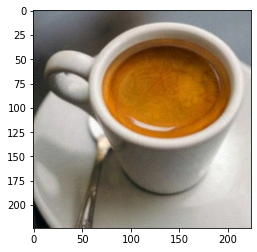

In [43]:
# Show the adversary picture
plt.imshow(espresso_adv[0].detach().numpy().transpose(1,2,0));

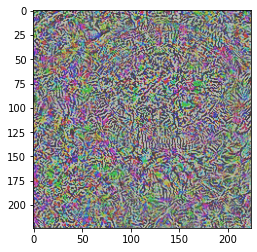

In [44]:
# Show the adversary change (amplified by a factor 20)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0));

In [49]:
# Prediction
pred_adv = model(normalize_resnet50(espresso_adv))
print("Predicted class: %d, %s" % (pred_adv.max(dim=1)[1].item(), imagenet_classes[pred_adv.max(dim=1)[1].item()]))
print("Probability: %f%%" % (nn.Softmax(dim=1)(pred_adv)[0,pred_adv.max(dim=1)[1].item()].item() * 100) )

Predicted class: 925, consomme
Probability: 99.993467%


## A targeted attack

In [59]:
target_class = "banana"

# Select label for a class of our choice
target_label = list(imagenet_classes.keys())[list(imagenet_classes.values()).index(target_class)] 

delta = torch.zeros_like(espresso_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

print("Generating adversary example targeted towards 'banana'...")
for t in range(100):
    pred = model(normalize_resnet50(espresso_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([train_against_label])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([target_label])))
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print("Done.")
print("Original class probability: %.10f%%" % (nn.Softmax(dim=1)(pred)[0,train_against_label].item() * 100) )

espresso_targeted_adv = (espresso_tensor + delta).data.clamp_(0,1)

Generating adversary example targeted towards 'banana'...
Done.
Original class probability: 0.0000000000%


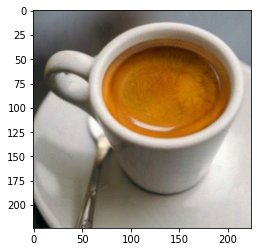

In [61]:
# Show the adversary picture
plt.imshow(espresso_targeted_adv[0].detach().numpy().transpose(1,2,0));

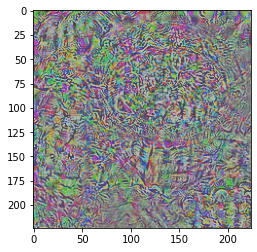

In [62]:
# Show the adversary change (amplified by a factor 20)
plt.imshow((20*delta+0.5)[0].detach().numpy().transpose(1,2,0));

In [65]:
# Prediction
pred_adv = model(normalize_resnet50(espresso_targeted_adv))
print("Predicted class: %d, %s" % (pred_adv.max(dim=1)[1].item(), imagenet_classes[pred_adv.max(dim=1)[1].item()]))
print("Probability: %f%%" % (nn.Softmax(dim=1)(pred_adv)[0,pred_adv.max(dim=1)[1].item()].item() * 100) )

Predicted class: 954, banana
Probability: 100.000000%


## Anti-adversarial

Adding some random (normal) noise could mitigate the adversarial power.

In [129]:
# Generate a bit of noise
import numpy as np
noise = torch.from_numpy(np.random.normal(0, 3e-2, espresso_tensor.shape)).float()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


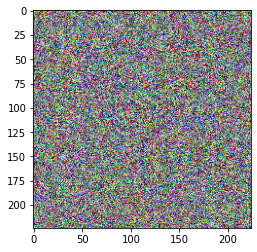

In [131]:
# Show noise
plt.imshow((10*(delta + noise)+0.5)[0].detach().numpy().transpose(1,2,0));

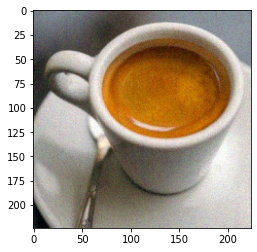

In [132]:
# Adversarial pig with random noise
anti_adversarial = (espresso_targeted_adv + noise).data.clamp_(0,1)
plt.imshow(anti_adversarial[0].detach().numpy().transpose(1,2,0));

In [134]:
# Prediction
pred_adv = model(normalize_resnet50(anti_adversarial))
print("Predicted class: %d, %s" % (pred_adv.max(dim=1)[1].item(), imagenet_classes[pred_adv.max(dim=1)[1].item()]))
print("Probability: %f%%" % (nn.Softmax(dim=1)(pred_adv)[0,pred_adv.max(dim=1)[1].item()].item() * 100) )
print("Probability of adversary class: %f%%" % (nn.Softmax(dim=1)(pred_adv)[0,target_label].item() * 100) )

Predicted class: 967, espresso
Probability: 99.510717%
Probability of adversary class: 0.000010%


In [139]:
# Analyse relation between noise stdev and class probabilities
noise_amps  = np.arange(0, .2, 0.001)
num_samples = 20

probs_cls = np.zeros((noise_amps.shape[0], num_samples))
probs_adv = np.zeros((noise_amps.shape[0], num_samples))

for i, noise_amp in enumerate(noise_amps):
    for n in range(num_samples):
        noise = torch.from_numpy(np.random.normal(0, noise_amp, espresso_tensor.shape)).float()
        anti_adversarial = (espresso_targeted_adv + noise).data.clamp_(0,1)
        pred_adv = model(normalize_resnet50(anti_adversarial))
        probs_cls[i, n] = nn.Softmax(dim=1)(pred_adv)[0,train_against_label].item()
        probs_adv[i, n] = nn.Softmax(dim=1)(pred_adv)[0,target_label].item()
    print("%s%d/%d" % ("" if i == 0 else ", ", i + 1, noise_amps.shape[0]), end = '')
print("\n")
    
probs_cls_mean = np.mean(probs_cls, axis = 1 )
probs_adv_mean = np.mean(probs_adv, axis = 1 )

1/200, 2/200, 3/200, 4/200, 5/200, 6/200, 7/200, 8/200, 9/200, 10/200, 11/200, 12/200, 13/200, 14/200, 15/200, 16/200, 17/200, 18/200, 19/200, 20/200, 21/200, 22/200, 23/200, 24/200, 25/200, 26/200, 27/200, 28/200, 29/200, 30/200, 31/200, 32/200, 33/200, 34/200, 35/200, 36/200, 37/200, 38/200, 39/200, 40/200, 41/200, 42/200, 43/200, 44/200, 45/200, 46/200, 47/200, 48/200, 49/200, 50/200, 51/200, 52/200, 53/200, 54/200, 55/200, 56/200, 57/200, 58/200, 59/200, 60/200, 61/200, 62/200, 63/200, 64/200, 65/200, 66/200, 67/200, 68/200, 69/200, 70/200, 71/200, 72/200, 73/200, 74/200, 75/200, 76/200, 77/200, 78/200, 79/200, 80/200, 81/200, 82/200, 83/200, 84/200, 85/200, 86/200, 87/200, 88/200, 89/200, 90/200, 91/200, 92/200, 93/200, 94/200, 95/200, 96/200, 97/200, 98/200, 99/200, 100/200, 101/200, 102/200, 103/200, 104/200, 105/200, 106/200, 107/200, 108/200, 109/200, 110/200, 111/200, 112/200, 113/200, 114/200, 115/200, 116/200, 117/200, 118/200, 119/200, 120/200, 121/200, 122/200, 123/200, 1

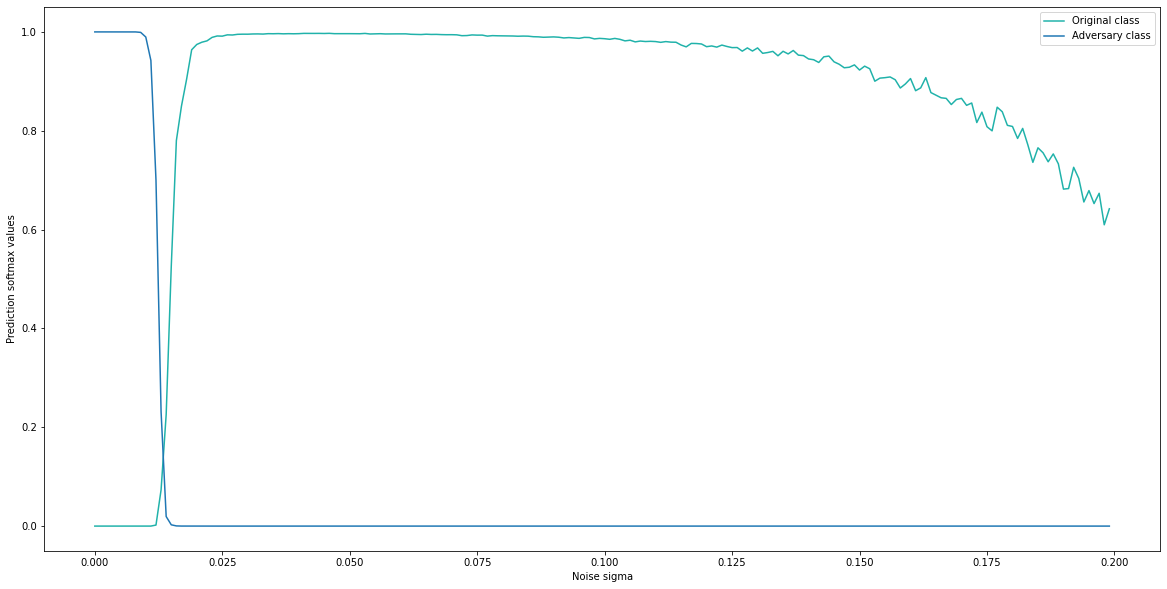

In [140]:
fig = plt.figure(figsize = (20,10));
ax  = fig.gca();
ax.plot(noise_amps, probs_cls_mean, label = "Original class", color = "lightseagreen");
ax.plot(noise_amps, probs_adv_mean, label = "Adversary class");
ax.set_xlabel("Noise sigma");
ax.set_ylabel("Prediction softmax values");
ax.legend(); 

In [141]:
# Rerun analysis with tighter interval
noise_amps  = np.arange(0, .03, 0.0001)
num_samples = 20

probs_cls = np.zeros((noise_amps.shape[0], num_samples))
probs_adv = np.zeros((noise_amps.shape[0], num_samples))

for i, noise_amp in enumerate(noise_amps):
    for n in range(num_samples):
        noise = torch.from_numpy(np.random.normal(0, noise_amp, espresso_tensor.shape)).float()
        anti_adversarial = (espresso_targeted_adv + noise).data.clamp_(0,1)
        pred_adv = model(normalize_resnet50(anti_adversarial))
        probs_cls[i, n] = nn.Softmax(dim=1)(pred_adv)[0,train_against_label].item()
        probs_adv[i, n] = nn.Softmax(dim=1)(pred_adv)[0,target_label].item()
    print("%s%d/%d" % ("" if i == 0 else ", ", i + 1, noise_amps.shape[0]), end = '')

probs_cls_mean = np.mean(probs_cls, axis = 1 )
probs_cls_std  = np.std(probs_cls, axis = 1 )
probs_adv_mean = np.mean(probs_adv, axis = 1 )
probs_adv_std  = np.std(probs_adv, axis = 1 )


1/300, 2/300, 3/300, 4/300, 5/300, 6/300, 7/300, 8/300, 9/300, 10/300, 11/300, 12/300, 13/300, 14/300, 15/300, 16/300, 17/300, 18/300, 19/300, 20/300, 21/300, 22/300, 23/300, 24/300, 25/300, 26/300, 27/300, 28/300, 29/300, 30/300, 31/300, 32/300, 33/300, 34/300, 35/300, 36/300, 37/300, 38/300, 39/300, 40/300, 41/300, 42/300, 43/300, 44/300, 45/300, 46/300, 47/300, 48/300, 49/300, 50/300, 51/300, 52/300, 53/300, 54/300, 55/300, 56/300, 57/300, 58/300, 59/300, 60/300, 61/300, 62/300, 63/300, 64/300, 65/300, 66/300, 67/300, 68/300, 69/300, 70/300, 71/300, 72/300, 73/300, 74/300, 75/300, 76/300, 77/300, 78/300, 79/300, 80/300, 81/300, 82/300, 83/300, 84/300, 85/300, 86/300, 87/300, 88/300, 89/300, 90/300, 91/300, 92/300, 93/300, 94/300, 95/300, 96/300, 97/300, 98/300, 99/300, 100/300, 101/300, 102/300, 103/300, 104/300, 105/300, 106/300, 107/300, 108/300, 109/300, 110/300, 111/300, 112/300, 113/300, 114/300, 115/300, 116/300, 117/300, 118/300, 119/300, 120/300, 121/300, 122/300, 123/300, 1

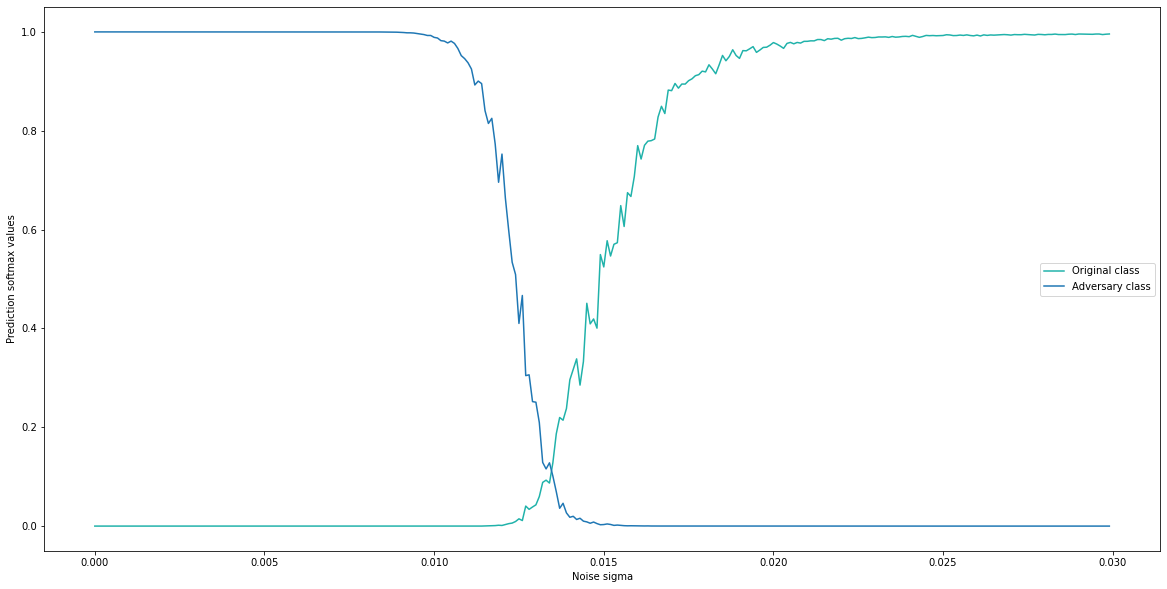

In [142]:
fig = plt.figure(figsize = (20,10));
ax  = fig.gca();
ax.plot(noise_amps, probs_cls_mean, label = "Original class", color = "lightseagreen");
ax.plot(noise_amps, probs_adv_mean, label = "Adversary class");
ax.set_xlabel("Noise sigma");
ax.set_ylabel("Prediction softmax values");
ax.legend(); 